# 00_1_DESIGN_Homologs

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/00_1_DESIGN_Homologs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
!pip install pydna
!pip install constrain
!pip install matplotlib
!pip install Bio

In [2]:
from Bio.Blast import NCBIWWW
from Bio.Seq import Seq
from Bio import SeqIO
blast = True
import pathlib
from Bio.Blast import NCBIXML
import pandas as pd
import numpy as np
import os


## 1. Intro

This notebook is made to be able to find homologs from protein queries. As a **test case** the G8H step in the Strictosidine pathway was chosen.  

**Some background on Strictosidine:** 
Strictosidine is a precurser for several anti-cancer compounds and is interesting because it is extracted from plants and due to weather and agricultural pests yields vary year to year (Brown et al., 2015). Additionally, Strictosidine is difficult to chemically synthesisze. Therefore we want to take the prouction to a yeast cell factory. However, the G8H (cytochrome p450) part of the pathway is the limiting step of the pathway and we want to optimize that via combinatorial optimizition. We have therefore chosen this step as test case for developing algorithms that can standardize homolog selection. The pathway is shown below.

This notebook has been developed to answer the following question:

**Can we via algorithms determine and standardize homolog selection?** 



In [3]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


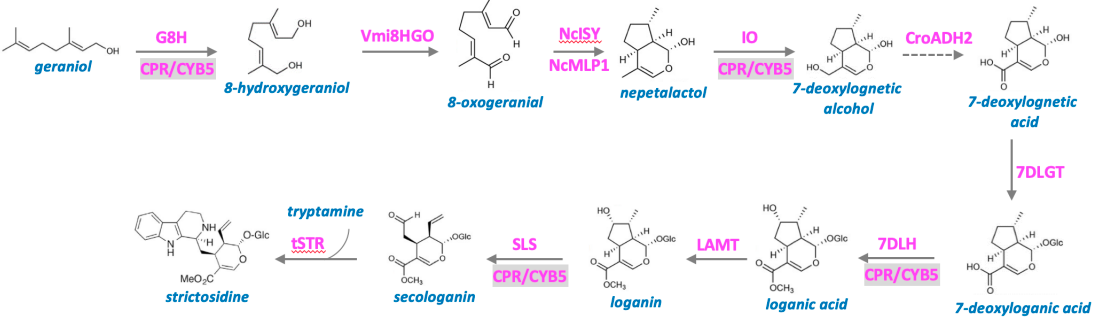

In [4]:
from IPython import display
display.Image('ConStrain_on_google_colab/pictures/Strictosidine_pathway.png')

**Main objective:**

- Finding Homologs for G8H, a major bottleneck in the Strictosidine pathway. More specifically two groups: 
    - G8H-CYP (Cytochrome p450)
    - G8H-CPR (Cytochrome p450 reductase)
    

**The method/algorithm for finding the set of homologs is described as follows:**

1. Read in the protein sequence of interest
2. BLAST the sequence with the Biopython NCBIWWW.qblast function and select “blastp”. 
3. Search through the newly generated alignment XML file and find proteins that fit your parameters and save ACC numbers. Parameters included here are: 
    - Identity: 50-95% 
    - E-value threshold 0.04
4. The ACC numbers are then used for fetching the protein sequences and saved as a FASTA file. 
5. The protein sequences are then made into DNA sequences in a 2 step process.
6. A temporary DNA sequence is made from a translation table
7. Codon optimized with “DNA chisel” for the organism of choice.
8. The codon-optimized sequences are made into Biopython SeqRecord objects and can be: 
    - Exported to a database of choice through an API (Benchling, Teselagen)
    - Saved as a FASTA file. 


## 2. G8H BLAST

First we make a file path for the fasta file we want to blast

In [5]:
pathCroG8H = 'ConStrain_on_google_colab/data/00-homologs/queries/Q8VWZ7.FASTA'

Then we read it into a Seqrecord object with biopython

In [6]:
croG8H = SeqIO.read(pathCroG8H, format="fasta")
croG8H

SeqRecord(seq=Seq('MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL...STL'), id='sp|Q8VWZ7|C76B6_CATRO', name='sp|Q8VWZ7|C76B6_CATRO', description='sp|Q8VWZ7|C76B6_CATRO Geraniol 8-hydroxylase OS=Catharanthus roseus OX=4058 GN=CYP76B6 PE=1 SV=1', dbxrefs=[])

In [7]:
print('LENGTH OF THE PROTEIN: ',len(croG8H.seq))
print(croG8H.seq)

LENGTH OF THE PROTEIN:  493
MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSLAKLSKKHGPIMSLKLGQITTIVISSSTMAKEVLQKQDLAFSSRSVPNALHAHNQFKFSVVWLPVASRWRSLRKVLNSNIFSGNRLDANQHLRTRKVQELIAYCRKNSQSGEAVDVGRAAFRTSLNLLSNLIFSKDLTDPYSDSAKEFKDLVWNIMVEAGKPNLVDFFPLLEKVDPQGIRHRMTIHFGEVLKLFGGLVNERLEQRRSKGEKNDVLDVLLTTSQESPEEIDRTHIERMCLDLFVAGTDTTSSTLEWAMSEMLKNPDKMKKTQDELAQVIGRGKTIEESDINRLPYLRCVMKETLRIHPPVPFLIPRKVEQSVEVCGYNVPKGSQVLVNAWAIGRDETVWDDALAFKPERFMESELDIRGRDFELIPFGAGRRICPGLPLALRTVPLMLGSLLNSFNWKLEGGMAPKDLDMEEKFGITLQKAHPLRAVPSTL


### 2.1 Blasting it on NCBI

I already did this - and it can take a while so have commented it out here.

In [8]:
#%%time
#result_handle = NCBIWWW.qblast("blastp", "nr", sequence=str(croG8H.seq),   hitlist_size=500) # format_type='Text', # 3000

## Write the blast onto an XML file 
#with open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_homologs.xml", "w") as blast_result: 
#    blast_result.write(result_handle.read())

#### 2.1.1 Open the generated file and read it into a variable 

In [9]:
from Bio.Blast import NCBIXML

with open("ConStrain_on_google_colab/data/00-homologs/blast_files/G8H_homologs.xml", "r") as result_handle:
    blast_record = NCBIXML.read(result_handle)

#### 2.1.2. Filter BLAST results, on E-value, percentage protein identity and display in a dataframe 
Note: The alignments are saved onto a Bio.Blast.Record.Alignment datatype

In [10]:
from constrain.design.retrieve_gene_homologs import filter_blast_results

In [11]:
alignments_saved = filter_blast_results(blast_record, show_alignment = False, ) 
alignments_saved

,Name,Identity,E_value,Length,ACC_number
0,geraniol 10-hydroxylase-like protein [Rauvolfi...,0.893878,0.0,493,AGX93053
1,geraniol 10-hydroxylase-like protein [Tabernae...,0.874239,0.0,493,AGX93054
2,geraniol 10-hydroxylase-like protein [Amsonia ...,0.866126,0.0,493,AGX93052
3,geraniol 10-hydroxylase-like protein [Cinchona...,0.839757,0.0,493,AGX93051
4,geraniol 10-hydroxylase [Gentiana rigescens],0.821501,0.0,515,ANW12210
...,...,...,...,...,...
510,cytochrome P450 [Arnebia euchroma],0.585020,0.0,497,AZU97081
511,putative geraniol 8-hydroxylase [Helianthus an...,0.595918,0.0,490,KAJ0715863
512,PREDICTED: geraniol 8-hydroxylase [Vitis vinif...,0.561368,0.0,498,XP_002276561
513,hypothetical protein CICLE_v10028268mg [Citrus...,0.566600,0.0,496,ESR36918


We need to narrow down the candidtates. One way to do this is to select is to take a range of amino acid identeties. another way is to limit the length to be more similar to the native enzyme


In [12]:
alignments_saved = alignments_saved[ alignments_saved['Length'] > len(croG8H)-50]
alignments_saved = alignments_saved[ alignments_saved['Length'] <len(croG8H)+50]
len(alignments_saved)

468

In [13]:
# Sorting the dataframe
alignments_saved = alignments_saved.sort_values(by='Identity', ascending=False)
alignments_saved

,Name,Identity,E_value,Length,ACC_number
0,geraniol 10-hydroxylase-like protein [Rauvolfi...,0.893878,0.0,493,AGX93053
1,geraniol 10-hydroxylase-like protein [Tabernae...,0.874239,0.0,493,AGX93054
2,geraniol 10-hydroxylase-like protein [Amsonia ...,0.866126,0.0,493,AGX93052
10,geraniol 10-hydroxylase-like protein [Vinca mi...,0.862069,0.0,493,AGX93055
3,geraniol 10-hydroxylase-like protein [Cinchona...,0.839757,0.0,493,AGX93051
...,...,...,...,...,...
481,geraniol 8-hydroxylase-like [Prunus dulcis] >e...,0.556452,0.0,499,XP_034199623
466,geraniol 8-hydroxylase-like [Vitis riparia] >r...,0.556225,0.0,499,XP_034683456
502,cytochrome p450 family 76 subfamily c polypept...,0.554435,0.0,499,KAH9777546
507,hypothetical protein CICLE_v10019651mg [Citrus...,0.554435,0.0,536,ESR53703


#### 2.1.3 Choosing homologs



The idea is to create a diverse library. Therefore I chose the following homologs with AA identeties ranging from our query to 66.6% AA identity.

In [14]:
chosen_homologs = ['AGX93055','AGX93051' ,'AGX93053' , 'BAP90522', 'XP_022858342', 'D1MI46','AES93118']

In [15]:
chosen_homologs_df = alignments_saved[alignments_saved['ACC_number'].isin(chosen_homologs)]
print(len(chosen_homologs_df))
chosen_homologs_df

7


,Name,Identity,E_value,Length,ACC_number
0,geraniol 10-hydroxylase-like protein [Rauvolfi...,0.893878,0.0,493,AGX93053
10,geraniol 10-hydroxylase-like protein [Vinca mi...,0.862069,0.0,493,AGX93055
3,geraniol 10-hydroxylase-like protein [Cinchona...,0.839757,0.0,493,AGX93051
7,geraniol 10-hydroxylase [Ophiorrhiza pumila],0.829615,0.0,512,BAP90522
13,RecName: Full=Geraniol 8-hydroxylase; AltName:...,0.805274,0.0,495,D1MI46
12,geraniol 8-hydroxylase-like [Olea europaea var...,0.803644,0.0,494,XP_022858342
456,geraniol-10-hydroxylase [Camptotheca acuminata],0.571717,0.0,501,AES93118


Additionally, we can add the query i.e the croG8H - Q8VWZ7

In [16]:
extra_G8H_dict = {'Name': 'geraniol-8-hydroxylase [Catharanthus roseus ]', 'Identity': 1, 'E_value': 0, 'Length':len(croG8H), 'ACC_number': 'Q8VWZ7' }
extra_G8H_df = pd.DataFrame([extra_G8H_dict])

chosen_homologs_df = pd.concat([chosen_homologs_df, extra_G8H_df], ignore_index=True)
chosen_homologs_df = chosen_homologs_df.sort_values(by = 'Identity', ascending = False)
chosen_homologs_df

,Name,Identity,E_value,Length,ACC_number
7,geraniol-8-hydroxylase [Catharanthus roseus ],1.000000,0.0,493,Q8VWZ7
0,geraniol 10-hydroxylase-like protein [Rauvolfi...,0.893878,0.0,493,AGX93053
1,geraniol 10-hydroxylase-like protein [Vinca mi...,0.862069,0.0,493,AGX93055
2,geraniol 10-hydroxylase-like protein [Cinchona...,0.839757,0.0,493,AGX93051
3,geraniol 10-hydroxylase [Ophiorrhiza pumila],0.829615,0.0,512,BAP90522
4,RecName: Full=Geraniol 8-hydroxylase; AltName:...,0.805274,0.0,495,D1MI46
5,geraniol 8-hydroxylase-like [Olea europaea var...,0.803644,0.0,494,XP_022858342
6,geraniol-10-hydroxylase [Camptotheca acuminata],0.571717,0.0,501,AES93118


In [17]:
acc_numbers = chosen_homologs_df['ACC_number'].tolist()
Names_species = chosen_homologs_df['Name'].tolist()
acc_numbers

['Q8VWZ7',
 'AGX93053',
 'AGX93055',
 'AGX93051',
 'BAP90522',
 'D1MI46',
 'XP_022858342',
 'AES93118']

## 3. Retrieve the sequences and write them onto a file

### 3.1 Getting DNA sequences through Entrez 

Retrieve the sequences with the Entrez library which is possible with the ACC numbers we found before. Save the retrieved sequences as a fasta file called 'Homolog_seqs.fasta'. You need to provide an email for this so they know who you are. 

In [18]:
acc_numbers

['Q8VWZ7',
 'AGX93053',
 'AGX93055',
 'AGX93051',
 'BAP90522',
 'D1MI46',
 'XP_022858342',
 'AES93118']

In [19]:
from constrain.design.fetch_sequences import retrieve_sequences_from_ncbi, read_fasta_files

In [20]:
chosen_g8h_ncbi_fasta = retrieve_sequences_from_ncbi(acc_numbers,'ConStrain_on_google_colab/data/00-homologs/protein_seqs/G8H_CYP_Homolog_seqs.fasta')
sequences = read_fasta_files('ConStrain_on_google_colab/data/00-homologs/protein_seqs/G8H_CYP_Homolog_seqs.fasta')
sequences 

[SeqRecord(seq=Seq('MDYLTIILTLLFALTLYEAFSYLSRRTKNLPPGPSPLPFIGSLHLLGDQPHKSL...STL'), id='sp|Q8VWZ7.1|C76B6_CATRO', name='sp|Q8VWZ7.1|C76B6_CATRO', description='sp|Q8VWZ7.1|C76B6_CATRO RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H', dbxrefs=[]),
 SeqRecord(seq=Seq('MDYLTITLGLLFALTFYQGLSYLSRRSKKLPPGPAPLPIIGNLHMLGDQPHKSL...IPF'), id='AGX93053.1', name='AGX93053.1', description='AGX93053.1 geraniol 10-hydroxylase-like protein [Rauvolfia serpentina]', dbxrefs=[]),
 SeqRecord(seq=Seq('MDYLTIALGLLFALTFYQGLTYLSRRSQKLPPGPLPLPIIGNLHLLGDHPHKSL...SPL'), id='AGX93055.1', name='AGX93055.1', description='AGX93055.1 geraniol 10-hydroxylase-like protein [Vinca minor]', dbxrefs=[]),
 SeqRecord(seq=Seq('MDYLTIVLGLLFALTLYQGLSSLSRKAKKLPPGPTPLPIIGNLHLLGDQPHKSL...ISL'), id='AGX93051.1', name='AGX93051.1', description='AGX93051.1 geraniol 10-hydroxylase-like protein [Cinchona calisaya]', dbxrefs=[]),
 SeqRecord(seq=Seq('MRILDSEVSKI

In [21]:
# Updating names 
sequences[0].id = 'Q8VWZ7'
sequences[5].id = 'D1MI46'

## 4. Codon optimize it for yeast

In [22]:
from dnachisel.biotools import reverse_translate

We can use DNA chisel to reverse_translate the sequences and afterwards codon optimize them. 

In [23]:
#add  * to indicate stop codon - and reverse traslate it
for seq in sequences: 
    seq.seq = reverse_translate(seq.seq + '*')

In [24]:
seq

SeqRecord(seq='ATGGATATTATGGATTTTATGTCTTTTTTTATTATGTTTTTTGGTCATTTACAAATTGTTTCTTCTCCTACTACTGCTGCTTCTTGTAAAGGTTGTAAAAAAGCTTCTACTGGTCCTAAACCTTTTCCTGTTATTGGTAATTTATTAGATGTTGTTGGTAATCAACCTCATAAATCTTTAGCTAATTTAGCTAAAACTCATGGTCCTTTAATGACTTTAAAATTAGGTCAAATTACTACTGTTGTTGTTTCTTCTTCTACTATGGCTAAACAAATTTTACAAAATCATGATTTATATTTTTCTAATCGTTATACTCGTGATGCTATTCGTGCTTTAAATCAAGATCAATTTTCTGTTATTTGGTTACCTGTTGTTACTCGTTGGCGTAATTTACGTAAAATTTTAAATTTATATATGTTATCTACTGAACGTTTAGGTGCTAATCAACCTATTCGTTGTCAAAAAGTTGAAGAATTAATTGCTTATGTTCGTCAATCTTGTCAAGCTTCTGTTTCTGTTGATATTGGTCAAGCTGCTTTTCGTACTATGATTAATTTAACTTCTAAAACTATTTTTTCTGTTGATTTAGCTGATCCTTCTTCTGATACTGCTCAAGAATTAAAAGAATTATTTTGGCGTATTATGGAAGAATTAGGTAAACCTAATTTAGCTGATTATTTTCCTGTTTTACGTAAATTAGATCCTCAAGGTATTCGTCGTCGTACTACTATTCATTTTGCTAAAGTTTTTGATTTATTTGATCGTATGATTGATCAACGTTTAGAATTATTACGTTCTGATGATTGTTGTACTGGTAATGATTTATTAGATTCTTTATTAAATATTTCTCAAAATAATTCTGATGAAATTGATCAAAATCAAATTAAACGTATGTTAATGGATGTTTTTATTGCTGCTACTGATACTACTTCTTCTACTTTAGAATGGGCTATGACTGAATTATTACGTAATCCTGAAACTTTAT

### 4.1 DNA chisel

Here the DNA is codon optimized for s_cerevisiae with DNA chisel

In [25]:
from constrain.design.retrieve_gene_homologs import codon_optimize_with_dnachisel

In [26]:
codon_optimized_sequences = codon_optimize_with_dnachisel(sequences)

location:   0%|                                | 0/184 [00:00<?, ?it/s, now=0-3]
                                                                                
location: 100%|████████████████████| 184/184 [00:00<00:00, 1557.04it/s, now=0-3]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -0.55
     -0.55 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -5.47E-01




location:   0%|                               | 0/169 [00:00<?, ?it/s, now=9-12]
                                                                                
location: 100%|███████████████████| 169/169 [00:00<00:00, 1176.01it/s, now=9-12]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -0.55
     -0.55 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -5.47E-01




location:   0%|                               | 0/164 [00:00<?, ?it/s, now=9-12]
                                                                                
location:   1%|                  | 1/164 [00:00<00:28,  5.76it/s, now=1338-1341]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -1.09E+00




location:   0%|                               | 0/166 [00:00<?, ?it/s, now=9-12]
                                                                                
location:   1%|                  | 1/166 [00:00<00:17,  9.38it/s, now=1161-1164]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1482](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:         0
✔        0 ┍ MaximizeCAI[0-1482](s_cerevisiae) 
           │ Codon opt. on window 0-1482 scored -0.00E+00




location:   0%|                                | 0/174 [00:00<?, ?it/s, now=3-6]
                                                                                
location: 100%|████████████████████| 174/174 [00:00<00:00, 1466.91it/s, now=3-6]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1539](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-1539](s_cerevisiae) 
           │ Codon opt. on window 0-1539 scored -1.09E+00




location:   0%|                              | 0/166 [00:00<?, ?it/s, now=18-21]
                                                                                
location: 100%|██████████████████| 166/166 [00:00<00:00, 1329.07it/s, now=18-21]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1488](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -2.19
     -2.19 ┍ MaximizeCAI[0-1488](s_cerevisiae) 
           │ Codon opt. on window 0-1488 scored -2.19E+00




location:   0%|                                | 0/178 [00:00<?, ?it/s, now=3-6]
                                                                                
location: 100%|████████████████████| 178/178 [00:00<00:00, 1625.60it/s, now=3-6]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1485](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.64
     -1.64 ┍ MaximizeCAI[0-1485](s_cerevisiae) 
           │ Codon opt. on window 0-1485 scored -1.64E+00




location:   0%|                               | 0/167 [00:00<?, ?it/s, now=9-12]
                                                                                
location:   1%|                  | 1/167 [00:00<00:25,  6.55it/s, now=1461-1464]
                                                                                

===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-1506](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -0.55
     -0.55 ┍ MaximizeCAI[0-1506](s_cerevisiae) 
           │ Codon opt. on window 0-1506 scored -5.47E-01




In [27]:
codon_optimized_sequences

[SeqRecord(seq=Seq('GTTGATTATGTTCCAGTTATGTCTACTTTGTTGTGGGCTTTGACTCCATATGTT...TAA'), id='Q8VWZ7', name='sp|Q8VWZ7.1|C76B6_CATRO', description='sp|Q8VWZ7.1|C76B6_CATRO RecName: Full=Geraniol 8-hydroxylase; AltName: Full=Cytochrome P450 76B6; AltName: Full=Geraniol 10-hydroxylase; Short=CrG10H', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATATGTCTATGACTTTGGGTTTGTTGTTGGCTTTGACTTCTTATCAA...TAA'), id='AGX93053.1', name='AGX93053.1', description='AGX93053.1 geraniol 10-hydroxylase-like protein [Rauvolfia serpentina]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATTTGACTATGGCTCCAGGTTTGATGTGTGCTTTGACTACTTATCAA...TAA'), id='AGX93055.1', name='AGX93055.1', description='AGX93055.1 geraniol 10-hydroxylase-like protein [Vinca minor]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGATTATTTGACTGTTGTTTCTGGTTTGGTTGTTGCTTTGACTTTGTATCAA...TAA'), id='AGX93051.1', name='AGX93051.1', description='AGX93051.1 geraniol 10-hydroxylase-like protein [Cinchona calisaya]', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGATGATTTTGGATTCTGAAGTTTCTA

Writing the sequences into a fasta_file

In [28]:
with open('ConStrain_on_google_colab/data/00-homologs/protein_seqs/G8H_CYP_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_sequences)):
        print(codon_optimized_sequences[i].format("fasta"), file = outfile)

## 5. CPR BLAST


- The CPR was found in the article: De novo production of the plant-derived alkaloid strictosidine in yeast, under suplementary information
- From the fasta-file we have the CPR protein sequece and we can repeat what was done above for finding G8H homologs 

In [29]:
G8H_CPR = SeqIO.read('ConStrain_on_google_colab/data/00-homologs/queries/Q05001.1.fasta', format="fasta")
G8H_CPR

SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='sp|Q05001.1|NCPR_CATRO', name='sp|Q05001.1|NCPR_CATRO', description='sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[])

### 5.1 Blasting on NCBI - and Write the blast onto an XML file 

Have already done this - if you want to try you can do it again or else move to the next cell were the results are loaded in.


In [30]:
#%%time
#result_handle1 = NCBIWWW.qblast("blastp", "nr", sequence = G8H_CPR.seq, hitlist_size=5000)
##
### Writing the results into an XML files so we dont have to blast every time
#blast_result1 = open("ConStrain_on_google_colab/Data/Protein_seqs/G8H_CPR_homologs_10000.xml", "w")
#blast_result1.write(result_handle1.read())
#blast_result1.close()
#
#result_handle1.close()

In [30]:
from Bio.Blast import NCBIXML

with open("ConStrain_on_google_colab/data/00-homologs/blast_files//G8H_CPR_homologs.xml", "r") as result_handle1:
    blast_record = NCBIXML.read(result_handle1)

#### 5.1.2 Filter BLAST results, on E-value, percentage protein identity and display in a dataframe

In [31]:
df_with_CPR = filter_blast_results(blast_record, show_alignment = False) 
df_with_CPR

,Name,Identity,E_value,Length,ACC_number
0,hypothetical protein M9H77_06302 [Catharanthus...,0.994398,0.000000e+00,714,KAI5675352
1,NADPH--cytochrome P450 reductase [Coffea eugen...,0.841737,0.000000e+00,712,XP_027176985
2,NADPH--cytochrome P450 reductase-like [Coffea ...,0.837535,0.000000e+00,712,XP_027072686
3,NADPH--cytochrome P450 reductase-like [Olea eu...,0.801120,0.000000e+00,708,XP_022867604
4,NADPH-cytochrome P450 reductase [Olea europaea...,0.799720,0.000000e+00,708,CAA3005731
...,...,...,...,...,...
5032,NADPH cytochrome P450 reductase [Fusarium dlam...,0.338931,3.517630e-106,692,AMD39143
5033,NADPH-cytochrome P450 reductase [Dissophora gl...,0.334722,3.593510e-106,718,KAG0308475
5034,cytochrome P450 reductase 1 [Aureobasidium sub...,0.347032,3.631240e-106,757,KAI5257244
5035,hypothetical protein K441DRAFT_662188 [Cenococ...,0.341945,3.779380e-106,696,OCK92979


Now we can sort the results in a dataframe 

Lets add our query Q05001

In [32]:
G8H_CPR.id = 'Q05001'
G8H_CPR_dict = {'Name': G8H_CPR.description, 'Identity': 1, 'E_value': 0, 'Length':len(G8H_CPR.seq), 'ACC_number': G8H_CPR.id }
CPR_df = pd.DataFrame([G8H_CPR_dict])

df_with_CPR = pd.concat([CPR_df, df_with_CPR], ignore_index=True)

filtering out queries

In [33]:
df_with_CPR = df_with_CPR[ df_with_CPR['Length'] > len(G8H_CPR)-100]
df_with_CPR = df_with_CPR[ df_with_CPR['Length'] <len(G8H_CPR)+100]
len(df_with_CPR)

4430

In [34]:
df_with_CPR = df_with_CPR.sort_values(by= 'Identity', ascending = False)
df_with_CPR

,Name,Identity,E_value,Length,ACC_number
0,sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cy...,1.000000,0.000000e+00,714,Q05001
1,hypothetical protein M9H77_06302 [Catharanthus...,0.994398,0.000000e+00,714,KAI5675352
24,unnamed protein product [Coffea canephora],0.850904,0.000000e+00,662,CDP02981
2,NADPH--cytochrome P450 reductase [Coffea eugen...,0.841737,0.000000e+00,712,XP_027176985
3,NADPH--cytochrome P450 reductase-like [Coffea ...,0.837535,0.000000e+00,712,XP_027072686
...,...,...,...,...,...
4511,NADPH--cytochrome P450 reductase [Drechslerell...,0.321330,6.205830e-110,723,EWC45357
4313,uncharacterized protein DIURU_004952 [Diutina ...,0.320169,1.217650e-111,678,XP_034010355
4542,NADPH--cytochrome P450 reductase [Kocuria palu...,0.318759,1.194760e-109,678,MCH0629128
4787,NADPH-dependent cytochrome P450 oxidoreductase...,0.314404,9.870500e-108,711,KAI7883845


#### 5.1.3 Choosing CPRs

In [36]:
df_with_CPR.to_csv('ConStrain_on_google_colab/data/00-homologs/protein_seqs/df_with_CPR_identity.csv', index = False)

df_with_CPR = pd.read_csv('ConStrain_on_google_colab/data/00-homologs/protein_seqs/df_with_CPR_identity.csv', index_col=False)

After reviewing this file the following CPRs looked promising: 
    
    - KAI5675352
    - XP_022867604
    - AJW67229
    - ABC47946
    - NP_194183
    - QEG78946
    - Q00141
    
and of course the native CPR 
    
    - Q05001
    
These have a large range of aminoacid identeties ranging from 0.34-0.99 which would ensure we have diverse enzymes which could include different enzyme mechanistics.

In [37]:
chosen_cprs= ['Q05001','KAI5675352', 'Q00141' , 'AJW67229', 'XP_022867604', 'QEG78946', 'ABC47946','NP_194183']

In [38]:
chosen_cpr_df = df_with_CPR[df_with_CPR['ACC_number'].isin(chosen_cprs)].sort_values(by=['Identity'], ascending=False)
chosen_cpr_df

,Name,Identity,E_value,Length,ACC_number
0,sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cy...,1.000000,0.000000e+00,714,Q05001
1,hypothetical protein M9H77_06302 [Catharanthus...,0.994398,0.000000e+00,714,KAI5675352
19,NADPH--cytochrome P450 reductase-like [Olea eu...,0.801120,0.000000e+00,708,XP_022867604
68,NADPH-cytochrome P450 reductase [Camptotheca a...,0.784916,0.000000e+00,708,AJW67229
464,cytochrome P450 reductase [Artemisia annua] >g...,0.741935,0.000000e+00,704,ABC47946
1198,P450 reductase 1 [Arabidopsis thaliana] >sp|Q9...,0.652303,0.000000e+00,692,NP_194183
1474,CpC573 [Chrysomela populi],0.407108,2.414150e-147,679,QEG78946
4318,RecName: Full=NADPH--cytochrome P450 reductase...,0.339939,1.672420e-108,694,Q00141


#### 5.1.5 Performing a BLAST on Phytometasyn transcriptome database


To further increase diversity of the library we decided to make a blast search on the database Phytometasyn transcriptome database : https://bioinformatics.tugraz.at/phytometasyn/


The query used was the X69791.1 C.roseus cpr mRNA for NADPH--ferrihemoprotein reductase i.e. the mRNA from the CPR in question - since the database does not use protein sequences for blast. https://www.ncbi.nlm.nih.gov/nuccore/X69791 



In [40]:
phytometasyn_cprs = read_fasta_files('ConStrain_on_google_colab/data/00-homologs/phytometasyn/20221216-093225_Phytometasyn_transcriptome_database.fasta')
phytometasyn_cprs[0]

SeqRecord(seq=Seq('AAAAAAAAAAAAAAAAAAAAAGAATATCTTAAGAACCAACCAACACTTGAAAAC...ACC'), id='MAGPIE:cov_COVLF1VD_Trinity--comp499_c0_seq1', name='MAGPIE:cov_COVLF1VD_Trinity--comp499_c0_seq1', description='MAGPIE:cov_COVLF1VD_Trinity--comp499_c0_seq1', dbxrefs=[])

These sequences are not in frame since they are just mRNA transcripts. By using some simple functions we can find the longest reading frames for the proteins and translate them to protein. 

In [41]:
from constrain.design.retrieve_gene_homologs import longest_orf

In [42]:
for seq in phytometasyn_cprs:
    # Find longest orf
    longest = Seq(longest_orf(str(seq.seq)))
    # translate it 
    translated = longest.translate()
    seq.seq = translated

In [43]:
from constrain.design.retrieve_gene_homologs import alignment_identity

In [44]:
percent_identity = alignment_identity(phytometasyn_cprs, G8H_CPR)
list_of_names = [name.name for name in phytometasyn_cprs]

d = {'list_of_names':list_of_names,'percent_identity':percent_identity}
df = pd.DataFrame(d)
df =  df.sort_values(by='percent_identity', ascending= False)
df

,list_of_names,percent_identity
4,MAGPIE:clo_CLOLF1VD_Trinity--comp713_c0_seq1,0.984594
6,MAGPIE:rse_RSERT1VD_Trinity--comp729_c1_seq1,0.922969
10,MAGPIE:ahu_AHUWL1VD_Velvet--Singlet39043,0.903361
16,MAGPIE:ahu_AHUWL1VD_Velvet--Contig15113,0.873950
15,MAGPIE:ahu_AHUWL1VD_Velvet--Singlet55805,0.873950
24,MAGPIE:cle_CLESL1VD_Trinity--comp34169_c0_seq1,0.850140
19,MAGPIE:ahu_AHUWL1VD_Velvet--Contig9735,0.841737
17,MAGPIE:vmi_VMIWL1VD_assembled--VMIWL1VD_rep_c2...,0.824930
26,MAGPIE:hma_HMAFL1JP_Trinity--comp907_c0_seq1,0.806723
27,MAGPIE:hma_HMAFL1JP_Trinity--comp907_c0_seq2,0.803922


From the table above it is clear that we have a wide span of identeties. To make keep the functionality of the enzymes we will choose from the top hits - namely hit 2 and 3. 

In [45]:
RseCPR = [phytometasyn_cprs[6]]
RseCPR[0].name = 'RseCPR'
RseCPR[0].description = 'RseCPR - Fetched from the Phytometasyn transcriptome database'


In [46]:
AhuCPR = [phytometasyn_cprs[10] ]
AhuCPR[0].name = 'AhuCPR'
AhuCPR[0].description = 'AhuCPR - Fetched from the Phytometasyn transcriptome database'


In [47]:
litterature_CPRs_RSE_and_AHU =  RseCPR +AhuCPR
percent_identity = alignment_identity(litterature_CPRs_RSE_and_AHU, G8H_CPR)


In [48]:
for i in range(len(litterature_CPRs_RSE_and_AHU[:])):
    listen = [litterature_CPRs_RSE_and_AHU[i].name,percent_identity[i],'NaN',len(litterature_CPRs_RSE_and_AHU[i].seq),litterature_CPRs_RSE_and_AHU[i].id]
    chosen_cpr_df.loc[len(chosen_cpr_df)] = listen

len(chosen_cpr_df)

10

In [49]:
chosen_cpr_df = chosen_cpr_df.sort_values(by= 'Identity', ascending = False)
chosen_cpr_df

,Name,Identity,E_value,Length,ACC_number
0,sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cy...,1.000000,0.0,714,Q05001
1,hypothetical protein M9H77_06302 [Catharanthus...,0.994398,0.0,714,KAI5675352
8,RseCPR,0.922969,NaN,715,MAGPIE:rse_RSERT1VD_Trinity--comp729_c1_seq1
9,AhuCPR,0.903361,NaN,715,MAGPIE:ahu_AHUWL1VD_Velvet--Singlet39043
19,NADPH--cytochrome P450 reductase-like [Olea eu...,0.801120,0.0,708,XP_022867604
68,NADPH-cytochrome P450 reductase [Camptotheca a...,0.784916,0.0,708,AJW67229
464,cytochrome P450 reductase [Artemisia annua] >g...,0.741935,0.0,704,ABC47946
1198,P450 reductase 1 [Arabidopsis thaliana] >sp|Q9...,0.652303,0.0,692,NP_194183
1474,CpC573 [Chrysomela populi],0.407108,0.0,679,QEG78946
4318,RecName: Full=NADPH--cytochrome P450 reductase...,0.339939,0.0,694,Q00141


Since we already have the sequences from the last we can just retrieve them from the first fasta file

### 5.2 Retrieve the sequences and write them onto a file

In [51]:
chosen_cpr_ncbi_fasta = retrieve_sequences_from_ncbi(chosen_cprs,'ConStrain_on_google_colab/data/00-homologs/protein_seqs/CPRs_from_literature_wide_range.fasta')
chosen_cpr_ncbi = read_fasta_files('ConStrain_on_google_colab/data/00-homologs/protein_seqs/CPRs_from_literature_wide_range.fasta')

In [52]:
chosen_cpr_ncbi

[SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='sp|Q05001.1|NCPR_CATRO', name='sp|Q05001.1|NCPR_CATRO', description='sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[]),
 SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='KAI5675352.1', name='KAI5675352.1', description='KAI5675352.1 hypothetical protein M9H77_06302 [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('MAQLDTLDLVVLAVLLVGSVAYFTKGTYWAVAKDPYASTGPAMNGAAKAGKTRN...VWS'), id='sp|Q00141.2|NCPR_ASPNG', name='sp|Q00141.2|NCPR_ASPNG', description='sp|Q00141.2|NCPR_ASPNG RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[]),
 SeqRecord(seq=Seq('MQSSSVKVSTFDLMSAILRGRSMDQTNVSFESGESPALAMLIENRELVMILTTS...DVW'), id='AJW67229.1', name='AJW67229.1', description='AJW67229.1 NADPH-cytochrome P450 reductase [Camptotheca acuminata]', dbxrefs=[]),
 SeqRecord(seq=Seq('MDSTSEKLSPFDF

Now we can add all our sequences together and then codon optimize 



In [53]:
all_cprs = chosen_cpr_ncbi + RseCPR + AhuCPR
all_cprs

[SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='sp|Q05001.1|NCPR_CATRO', name='sp|Q05001.1|NCPR_CATRO', description='sp|Q05001.1|NCPR_CATRO RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[]),
 SeqRecord(seq=Seq('MDSSSEKLSPFELMSAILKGAKLDGSNSSDSGVAVSPAVMAMLLENKELVMILT...DVW'), id='KAI5675352.1', name='KAI5675352.1', description='KAI5675352.1 hypothetical protein M9H77_06302 [Catharanthus roseus]', dbxrefs=[]),
 SeqRecord(seq=Seq('MAQLDTLDLVVLAVLLVGSVAYFTKGTYWAVAKDPYASTGPAMNGAAKAGKTRN...VWS'), id='sp|Q00141.2|NCPR_ASPNG', name='sp|Q00141.2|NCPR_ASPNG', description='sp|Q00141.2|NCPR_ASPNG RecName: Full=NADPH--cytochrome P450 reductase; Short=CPR; Short=P450R', dbxrefs=[]),
 SeqRecord(seq=Seq('MQSSSVKVSTFDLMSAILRGRSMDQTNVSFESGESPALAMLIENRELVMILTTS...DVW'), id='AJW67229.1', name='AJW67229.1', description='AJW67229.1 NADPH-cytochrome P450 reductase [Camptotheca acuminata]', dbxrefs=[]),
 SeqRecord(seq=Seq('MDSTSEKLSPFDF

In [54]:
# some of the IDs have to be changed 
cpr_ids =['Q05001', 'KAI5675352','Q00141','AJW67229','XP_022867604','QEG78946','ABC47946','NP_194183','RseCPR', 'AhuCPR']
list_of_names = ['CroCPR', 
                 'CloCPR', 
                 'AniCPR',
                 'CacCPR',
                 'OeuCPR',
                 'CpoCPR',
                 'AanCPR',
                 'AthCPR',
                 'RseCPR', 
                 'AhuCPR']

for i in range(len(all_cprs)): 
    all_cprs[i].id = cpr_ids[i]
    all_cprs[i].name  = list_of_names[i]
    
    
len(all_cprs)

10

In [54]:
len(all_cprs)

10

In [55]:
with open("ConStrain_on_google_colab/data/00-homologs/protein_seqs/G8H_CPR_homolog_protein_seqs.fasta", "w") as output_handle:
    SeqIO.write(all_cprs, output_handle, "fasta")

### 5.3 Codon optimize it for yeast

We can do the same as before of first making a dummy dna sequence with the use of the synbiopython translation table

In [56]:
#add  * to indicate stop codon - and reverse traslate it
for seq in all_cprs: 
    seq.seq = reverse_translate(seq.seq + '*')

#### Now for making codon_optimized DNA from our protein sequences:  DNA chisel

In [57]:
codon_optimized_cprs = codon_optimize_with_dnachisel(all_cprs)

location:   0%|                              | 0/189 [00:00<?, ?it/s, now=15-18]
                                                                                
location: 100%|██████████████████| 189/189 [00:00<00:00, 1451.20it/s, now=15-18]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2145](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -2.19
     -2.19 ┍ MaximizeCAI[0-2145](s_cerevisiae) 
           │ Codon opt. on window 0-2145 scored -2.19E+00




location:   0%|                              | 0/198 [00:00<?, ?it/s, now=21-24]
                                                                                
location: 100%|██████████████████| 198/198 [00:00<00:00, 1610.57it/s, now=21-24]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2145](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-2145](s_cerevisiae) 
           │ Codon opt. on window 0-2145 scored -1.09E+00




location:   0%|                                | 0/185 [00:00<?, ?it/s, now=0-3]
                                                                                
location: 100%|████████████████████| 185/185 [00:00<00:00, 1169.07it/s, now=0-3]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2085](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -2.73
     -2.73 ┍ MaximizeCAI[0-2085](s_cerevisiae) 
           │ Codon opt. on window 0-2085 scored -2.73E+00




location:   0%|                                | 0/187 [00:00<?, ?it/s, now=3-6]
                                                                                
location: 100%|███████████████| 187/187 [00:00<00:00, 906.67it/s, now=1242-1245]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2127](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -2.19
     -2.19 ┍ MaximizeCAI[0-2127](s_cerevisiae) 
           │ Codon opt. on window 0-2127 scored -2.19E+00




location:   0%|                              | 0/205 [00:00<?, ?it/s, now=12-15]
                                                                                
location: 100%|██████████████████| 205/205 [00:00<00:00, 1946.08it/s, now=12-15]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2127](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-2127](s_cerevisiae) 
           │ Codon opt. on window 0-2127 scored -1.09E+00




location:   0%|                              | 0/212 [00:00<?, ?it/s, now=21-24]
                                                                                
location:   0%|                  | 1/212 [00:00<00:35,  5.86it/s, now=1767-1770]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2040](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-2040](s_cerevisiae) 
           │ Codon opt. on window 0-2040 scored -1.09E+00




location:   0%|                              | 0/180 [00:00<?, ?it/s, now=12-15]
                                                                                
location: 100%|██████████████████| 180/180 [00:00<00:00, 1773.26it/s, now=12-15]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2115](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:         0
✔        0 ┍ MaximizeCAI[0-2115](s_cerevisiae) 
           │ Codon opt. on window 0-2115 scored -0.00E+00




location:   0%|                               | 0/189 [00:00<?, ?it/s, now=9-12]
                                                                                
location: 100%|███████████████████| 189/189 [00:00<00:00, 1385.99it/s, now=9-12]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2079](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -3.28
     -3.28 ┍ MaximizeCAI[0-2079](s_cerevisiae) 
           │ Codon opt. on window 0-2079 scored -3.28E+00




location:   0%|                               | 0/198 [00:00<?, ?it/s, now=9-12]
                                                                                
location: 100%|███████████████████| 198/198 [00:00<00:00, 1786.28it/s, now=9-12]


===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2148](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -1.09
     -1.09 ┍ MaximizeCAI[0-2148](s_cerevisiae) 
           │ Codon opt. on window 0-2148 scored -1.09E+00




location:   0%|                                | 0/191 [00:00<?, ?it/s, now=6-9]
                                                                                
location: 100%|████████████████████| 191/191 [00:00<00:00, 1190.95it/s, now=6-9]
                                                                                

===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceGCContent[0-2148](mini:0.30, maxi:0.70, window:50)
      │ Passed !


===> TOTAL OBJECTIVES SCORE:     -0.55
     -0.55 ┍ MaximizeCAI[0-2148](s_cerevisiae) 
           │ Codon opt. on window 0-2148 scored -5.47E-01




Writing the sequences into a fasta_file

In [58]:
with open('ConStrain_on_google_colab/data/00-homologs/protein_seqs/G8H_CPR_homologs_codon_optimized.fasta', 'w') as outfile:
    for i in range(0, len(codon_optimized_cprs)):
        print(codon_optimized_cprs[i].format("fasta"), file = outfile)

<!-- My_api_key:

4772e3e5-57ce-4b75-a3a8-06c49a2e202d -->

## 6. Phylogenetic tree

So there are a few alignment tools for python but most of them are full of bugs. Therefore the protein sequences can just be entered to this website and from there we can download an alignment file for making phylogenetic trees.

### 6.1 G8H

In [59]:
from Bio import AlignIO

alignment = AlignIO.read(open("ConStrain_on_google_colab/data/00-homologs/alignment_files/aln-stockholm_g8h.txt"), "stockholm")
print("Alignment length %i" % alignment.get_alignment_length())

Alignment length 517


In [60]:
list_of_names = ['CacG8H', 'SmuG8H','OeuG8H','VmiG8H','CroG8H','RseG8H','CcaG8H','OpuG8H']
alignment[4].id = 'Q8VWZ7.1'
alignment[1].id = 'D1MI46.1'

# Updating Ids for ncícer plotting
for i in range(len(alignment)):
    alignment[i].id = f"{list_of_names[i]} ({alignment[i].id})"

In [61]:
from constrain.plotting.plotting import plot_phylo_tree

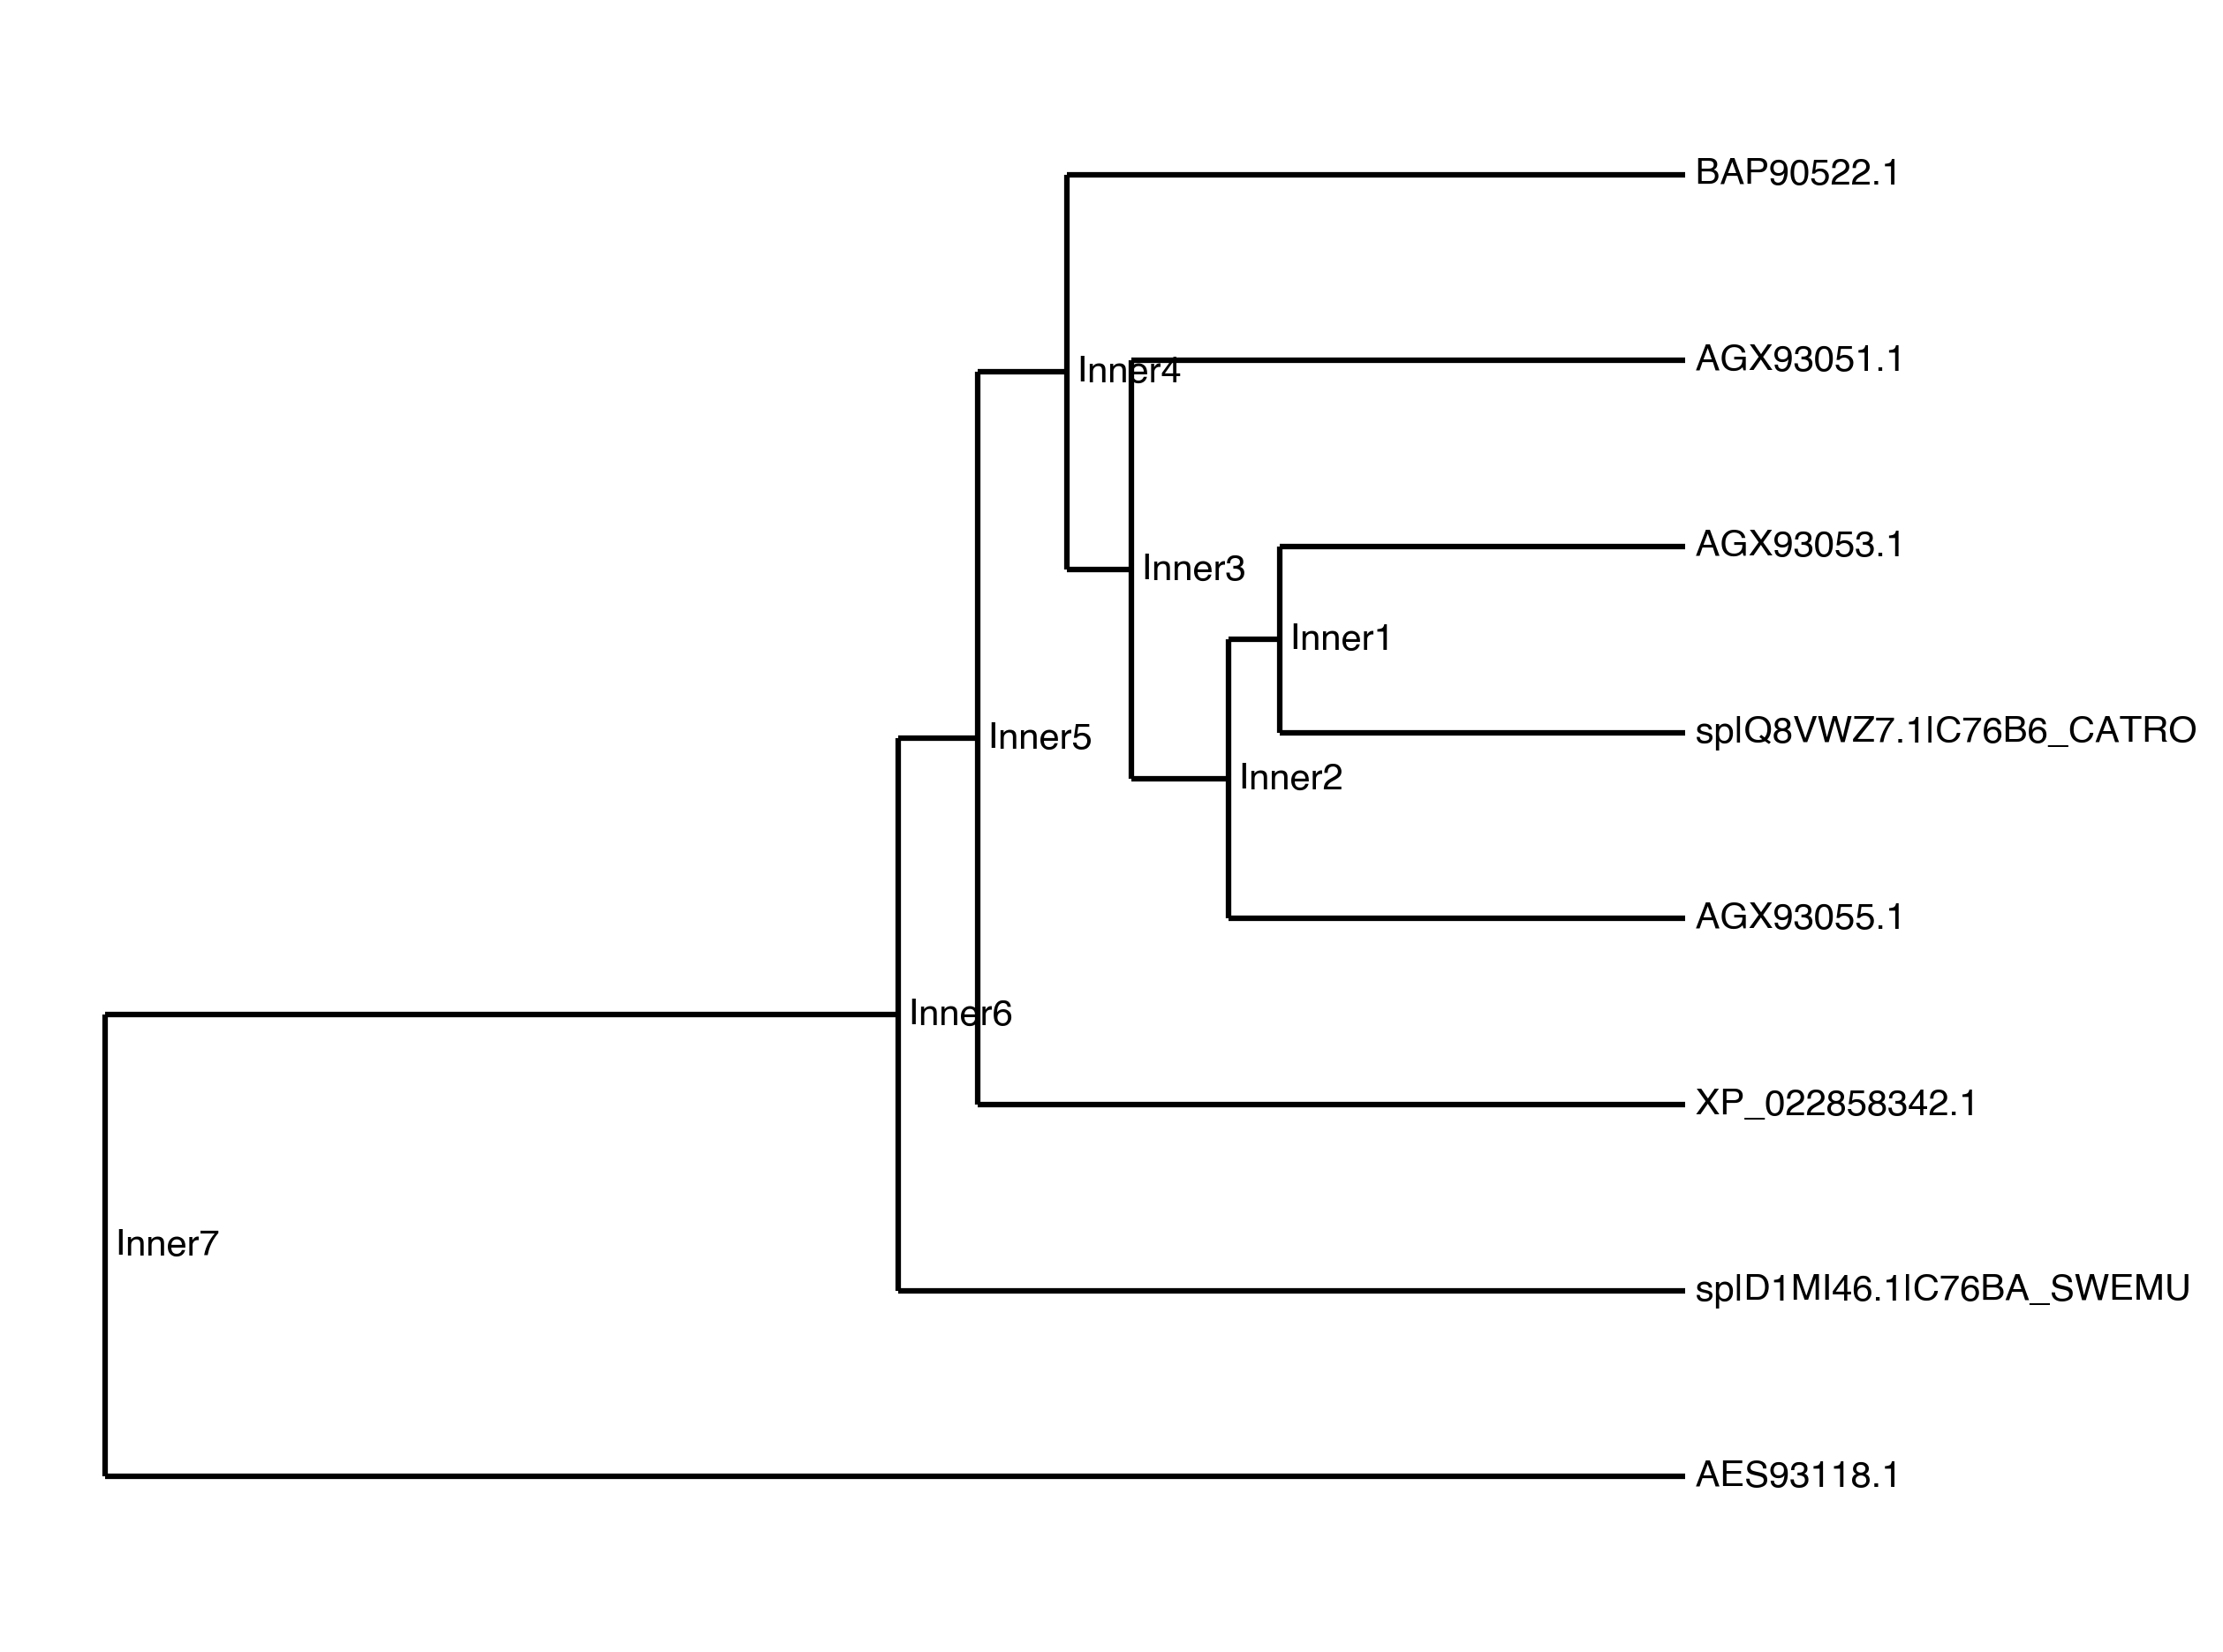

In [62]:
plot_phylo_tree(alignment, path = 'ConStrain_on_google_colab/data/10-plots/00_1_DESIGN_Homologs/G8H_phylo_tree')

### 6.2 CPR



In [63]:
from Bio import AlignIO

alignment = AlignIO.read(open("ConStrain_on_google_colab/data/00-homologs/alignment_files/aln-stockholm_CPR.txt"), "stockholm")
print("Alignment length %i" % alignment.get_alignment_length())

Alignment length 761


In [64]:
list_of_names = ['AniCPR',
                 'CpoCPR',
                 'AthCPR',
                 'AanCPR',
                 'CacCPR',
                 'OeuCPR',
                 'AhuCPR',
                 'RseCPR',
                 'CroCPR', 
                 'CloCPR' ]


# Updating Ids for ncícer plotting
for i in range(len(alignment)):
    alignment[i].id = f"{list_of_names[i]} ({alignment[i].id})"

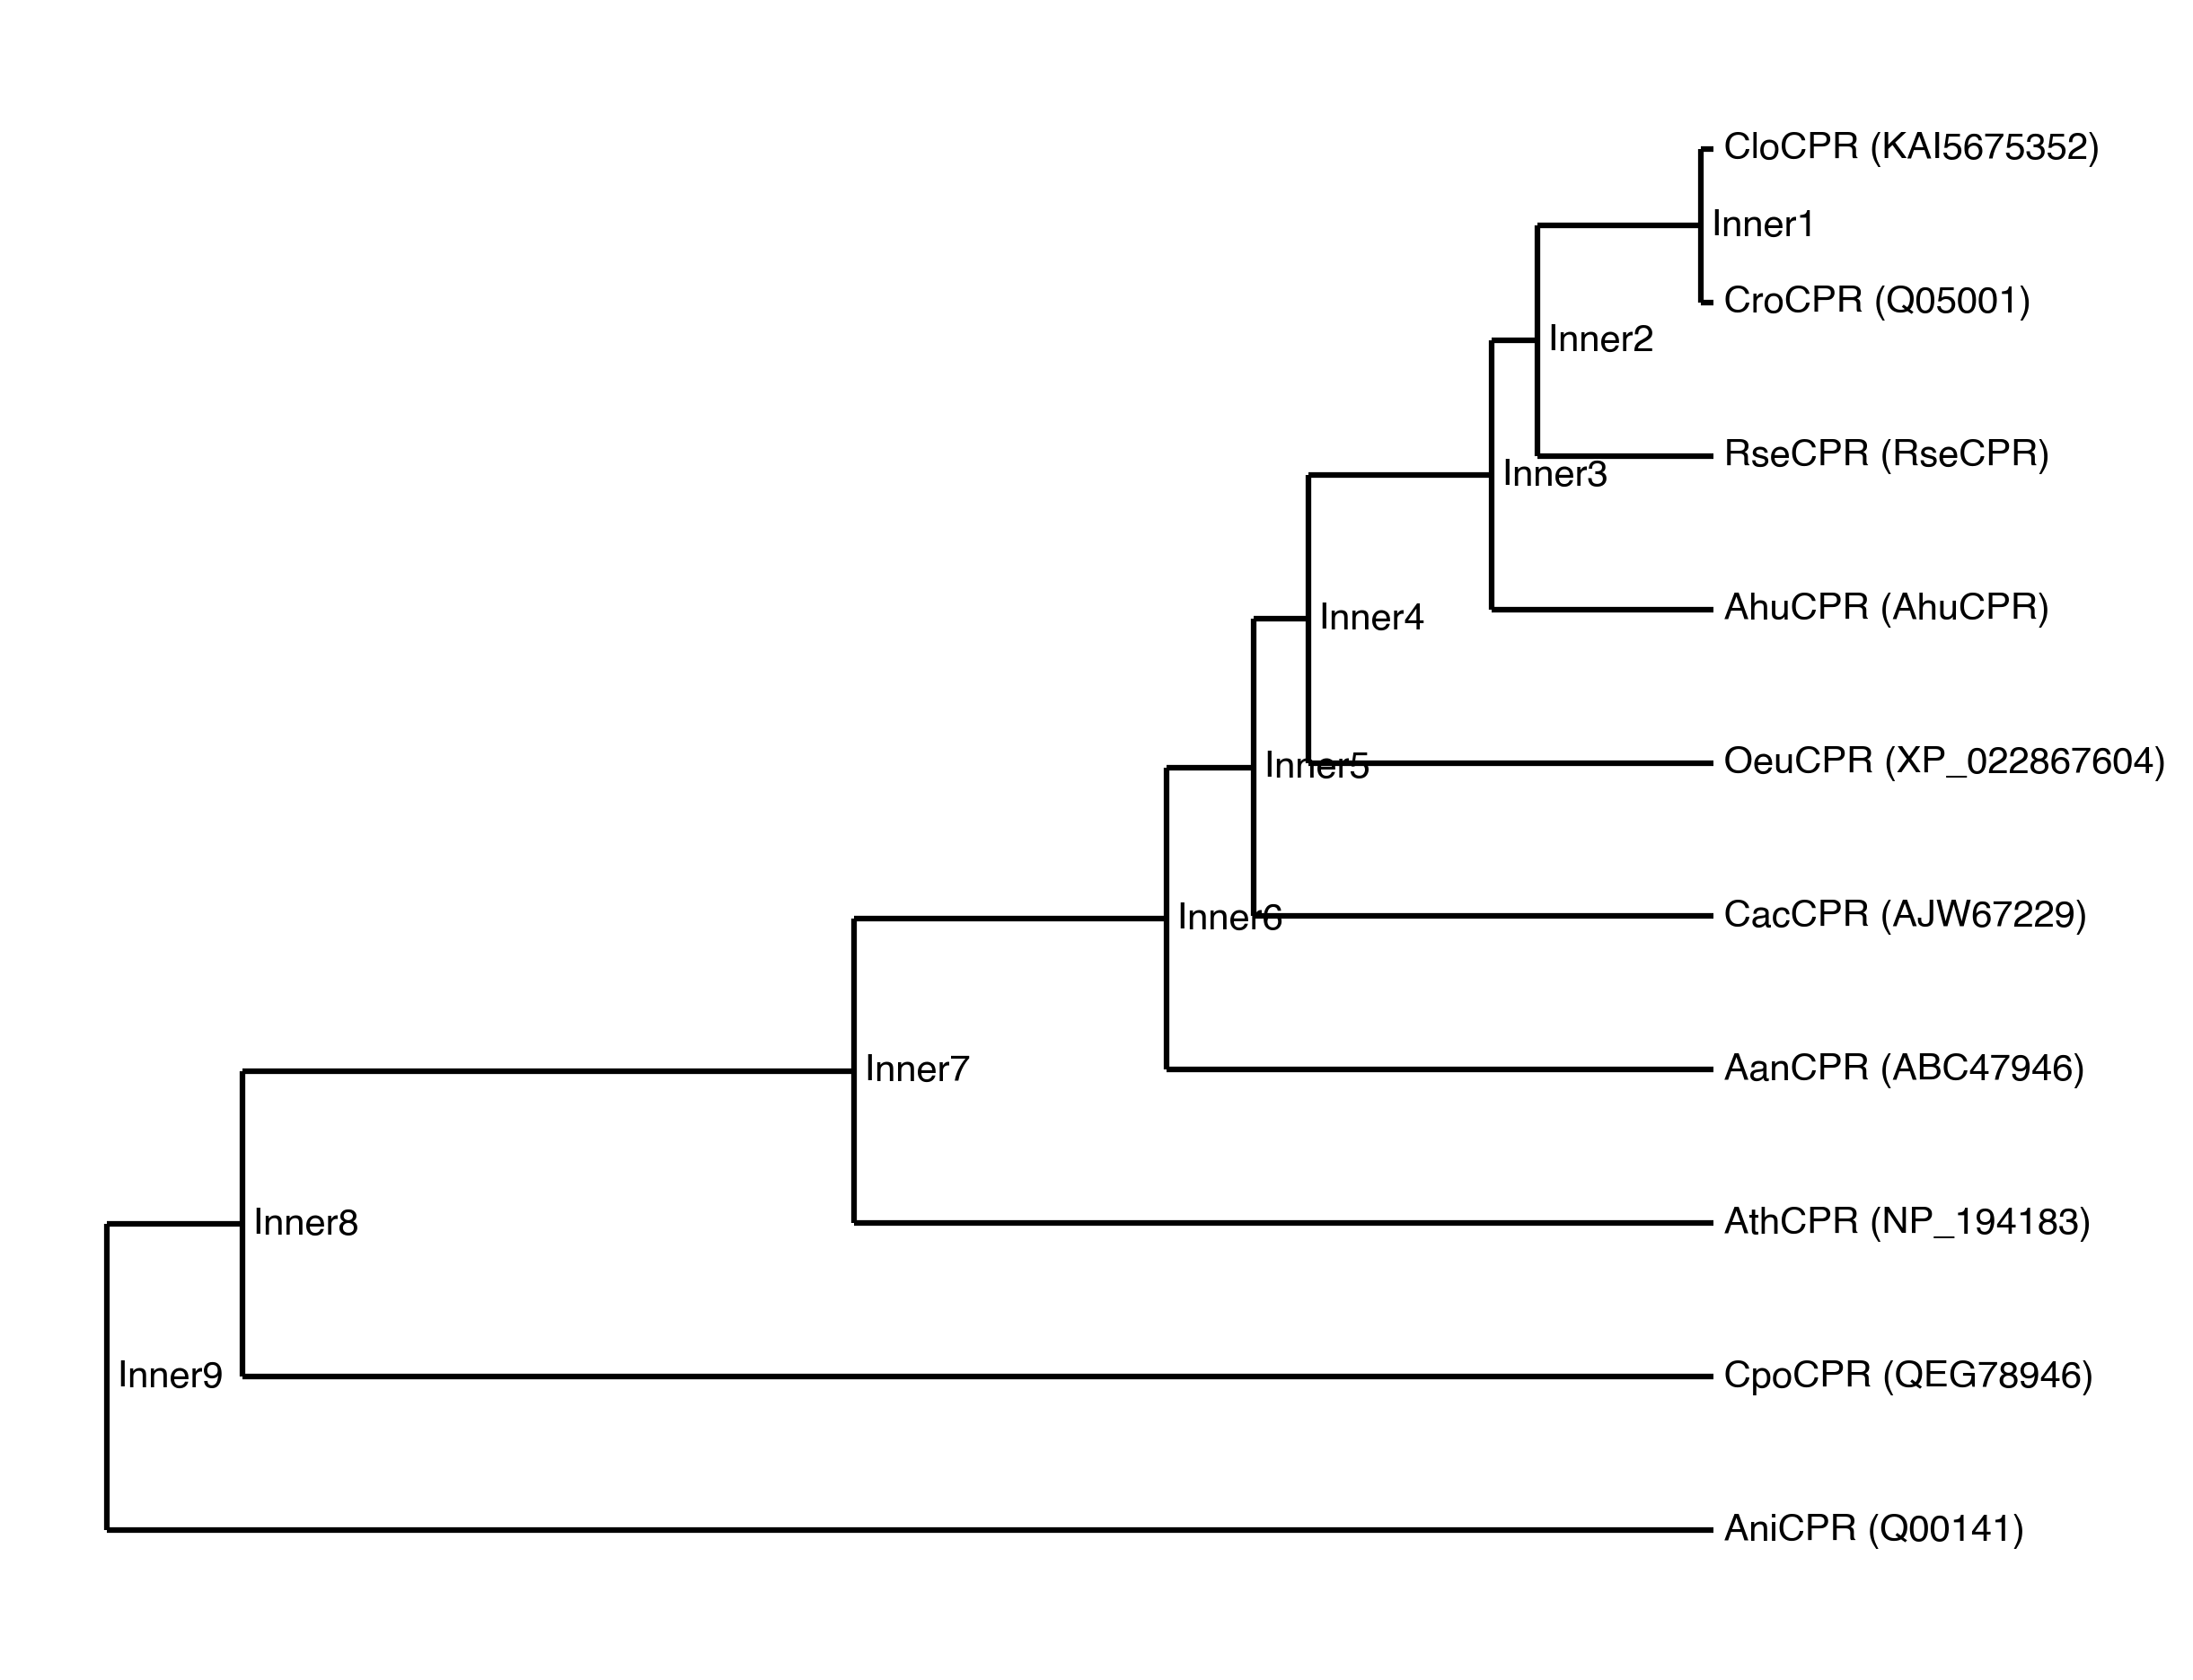

In [66]:
plot_phylo_tree(alignment, path = 'ConStrain_on_google_colab/data/10-plots/00_1_DESIGN_Homologs/CPR_phylo_tree')

## 7. Conclusion 

- 8 G8H CYPs were found and codon-optimized
- 10 CPRs were found and codon-optimized

## References: 
    
    
    

Brown, S., Clastre, M., Courdavault, V. and O’Connor, S., 2015. De novo production of the plant-derived alkaloid strictosidine in yeast. Proceedings of the National Academy of Sciences, 112(11), pp.3205-3210.